# Replicating Maliar, Maliar, and Valli (2010, JEDC) to solve Krusell and Smith (1998, JPE) model using Julia


By [Shunsuke Hori](https://github.com/Shunsuke-Hori)


# Overview of the notebook
This notebook solves the model of [Krusell and Smith (1998, JPE)](https://www.journals.uchicago.edu/doi/10.1086/250034) and succesfully replicating the result of [Maliar, Maliar, and Valli (2010, JEDC)](https://www.sciencedirect.com/science/article/pii/S0165188909001328).

The solution strategy is as follows

1. Solve the individual problem by Euler equation method or value function iteration (VFI) with 2D interpolation
    - Agents are boundedly rational. In the code, they take into account the information about the mean of capital
    - Aggregate law of motion is approximated by log-linear relation, i.e. $\log(K_{t+1})=B1+B2\log(K_{t})$ for good aggregate state and $\log(K_{t+1})=B3+B4\log(K_{t})$ for bad aggregate state 
    - If specified, Howard's policy iteration is used
1. Compute the path of aggregate capital using the policy function obtained by 1. There are two ways of simulation:
    - Monte Carlo following Krusell and Smith (1998). That is, aggregate technology shocks and idiosyncratic employment shocks are drawn for many agents and many periods. Then, using the LLN, the aggregate capital is computed by aggregating all agents for all period.
    - Non-stochastic method following [Young (2010, JEDC)](https://www.sciencedirect.com/science/article/pii/S0165188909001316).
1. Update the coefficient of aggregate capital law of motion, $B1$, $B2$, $B3$ and $B4$, by regression
1. Check convergence of $B1$, $B2$, $B3$ and $B4$

NOTE: Regarding interpolation, Krusell and Smith uses various interpolation scheme depending on the purpose, including polynomial interpolation. Maliar, Maliar, and Valli uses spline interpolation in their paper. This notebook only uses linear interpolation.

This notebook written in Julia solves the model much faster than the code of Maliar et al. (2010) written in Matlab according to [den Haan (2010, JEDC)](https://www.sciencedirect.com/science/article/pii/S0165188909001298), although they are not simply comparable because initial guess, interpolation methods, and running environments are different.

# Code to solve models

First thing to do is importing functions from `KSfunctions.ipynb`.

You can find the notebook in the [QuantEcon repositoy](https://github.com/QuantEcon/krusell_smith_code).

In [1]:
using NBInclude
@nbinclude("KSfunctions.ipynb")
using Plots      # to plot the result
pyplot()

Plots.PyPlotBackend()

## Implementation by Euler method

First, construct a `NamedTuple`, `ksp`, which contains the parameters of the model and `kss` which has initial guess of the solution.

(Grid size inconsistency is also checked, which may return error when exiting result is loaded by `load_value=true`)

In [2]:
# instance of KSParameter
ksp = KSParameter()
# instance of KSSolution
kss = KSSolution(ksp, load_value=false, load_B=false)
if size(kss.k_opt,1) != length(ksp.k_grid)
    error("loaded data is inconsistent with k_size")
end
if size(kss.k_opt,2) != length(ksp.K_grid)
    error("loaded data is inconsistent with K_size")
end

Let's draw the shock for stochastic simulation of aggregate law of motion

In [3]:
# generate shocks
Random.seed!(0) # for reproducability
@time zi_shocks, epsi_shocks =generate_shocks(ksp;
        z_shock_size=1100, population=10000);

  2.722285 seconds (3.38 M allocations: 551.803 MiB, 14.96% gc time)


Now, the following cell solves the model with Euler equation method

In [4]:
# find ALM coefficient
sm = Stochastic(epsi_shocks)
T_discard = 100
@time K_ts = find_ALM_coef!(EulerMethod(),
            sm, ksp, kss, zi_shocks, 
            tol_ump = 1e-8, max_iter_ump = 10000,
            tol_B = 1e-8, max_iter_B = 500, update_B = 0.3,
            T_discard = T_discard);

 --- Iteration over ALM coefficient: 1 ---


Solving individual UMP by Euler method:  Time: 0:00:49 (1868 iterations))
simulating aggregate path ...100%|██████████████████████| Time: 0:01:22


difference of ALM coefficient is 0.45732427121929203 and B = [0.457324, 0.876843, 0.437344, 0.880636]
 --- Iteration over ALM coefficient: 2 ---


Solving individual UMP by Euler method:  Time: 0:00:58 (2005 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.013376294857700866 and B = [0.139553, 0.962866, 0.117827, 0.967197]
 --- Iteration over ALM coefficient: 3 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52
Solving individual UMP by Euler method:  Time: 0:00:34 (1425 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.007529530931877415 and B = [0.145434, 0.961389, 0.125839, 0.965189]
 --- Iteration over ALM coefficient: 4 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:51
Solving individual UMP by Euler method:  Time: 0:00:43 (1536 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.006751190893555692 and B = [0.146914, 0.96097, 0.127194, 0.964838]
 --- Iteration over ALM coefficient: 5 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:53
Solving individual UMP by Euler method:  Time: 0:00:40 (1478 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.006949867818305117 and B = [0.149138, 0.960389, 0.130111, 0.964094]
 --- Iteration over ALM coefficient: 6 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:48
Solving individual UMP by Euler method:  Time: 0:00:37 (1504 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.006920069330592693 and B = [0.151193, 0.959844, 0.133629, 0.963172]
 --- Iteration over ALM coefficient: 7 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:50
Solving individual UMP by Euler method:  Time: 0:00:35 (1493 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.00694718079446266 and B = [0.152435, 0.959511, 0.136544, 0.962399]
 --- Iteration over ALM coefficient: 8 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:47
Solving individual UMP by Euler method:  Time: 0:00:37 (1457 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.006722163986636137 and B = [0.153018, 0.959354, 0.138403, 0.961906]
 --- Iteration over ALM coefficient: 9 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52
Solving individual UMP by Euler method:  Time: 0:00:42 (1417 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.005897742408243367 and B = [0.153293, 0.959281, 0.139595, 0.961591]
 --- Iteration over ALM coefficient: 10 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:50
Solving individual UMP by Euler method:  Time: 0:00:34 (1377 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.005054266904291199 and B = [0.15346, 0.959236, 0.140521, 0.961346]
 --- Iteration over ALM coefficient: 11 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:50
Solving individual UMP by Euler method:  Time: 0:00:33 (1335 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.004035289699137801 and B = [0.15353, 0.959218, 0.141018, 0.961214]
 --- Iteration over ALM coefficient: 12 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52
Solving individual UMP by Euler method:  Time: 0:00:40 (1290 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0032224775860056343 and B = [0.153588, 0.959202, 0.141416, 0.961109]
 --- Iteration over ALM coefficient: 13 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:56
Solving individual UMP by Euler method:  Time: 0:00:30 (1252 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.002538977211810678 and B = [0.153601, 0.959199, 0.141699, 0.961034]
 --- Iteration over ALM coefficient: 14 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:47


Solving individual UMP by Euler method:  Time: 0:00:29 (1203 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.001943945722092888 and B = [0.153602, 0.959199, 0.141866, 0.96099]
 --- Iteration over ALM coefficient: 15 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:50
Solving individual UMP by Euler method:  Time: 0:00:32 (1152 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0015086526630891939 and B = [0.153583, 0.959203, 0.142014, 0.96095]
 --- Iteration over ALM coefficient: 16 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:00
Solving individual UMP by Euler method:  Time: 0:00:36 (1087 iterations))
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0010862755331306762 and B = [0.153549, 0.959212, 0.142044, 0.960942]
 --- Iteration over ALM coefficient: 17 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:51
Solving individual UMP by Euler method:  Time: 0:00:29 (1020 iterations))
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0008088499380103642 and B = [0.153519, 0.95922, 0.142093, 0.960929]
 --- Iteration over ALM coefficient: 18 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:53
Solving individual UMP by Euler method:  Time: 0:00:25 (932 iterations))m
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.0005739777491678977 and B = [0.153486, 0.959228, 0.1421, 0.960926]
 --- Iteration over ALM coefficient: 19 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:54
Solving individual UMP by Euler method:  Time: 0:00:23 (815 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.00039404617945887344 and B = [0.153448, 0.959238, 0.142093, 0.960928]
 --- Iteration over ALM coefficient: 20 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:57
Solving individual UMP by Euler method:  Time: 0:00:19 (758 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 0.00023283842657845222 and B = [0.153414, 0.959247, 0.14205, 0.960939]
 --- Iteration over ALM coefficient: 21 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52
Solving individual UMP by Euler method:  Time: 0:00:18 (740 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 0.00013822097346735673 and B = [0.153397, 0.959251, 0.142025, 0.960946]
 --- Iteration over ALM coefficient: 22 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:04
Solving individual UMP by Euler method:  Time: 0:00:20 (673 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 8.06687554061325e-5 and B = [0.153392, 0.959253, 0.142009, 0.96095]
 --- Iteration over ALM coefficient: 23 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:27
Solving individual UMP by Euler method:  Time: 0:00:25 (503 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 5.315201402597558e-5 and B = [0.15339, 0.959253, 0.142005, 0.960951]
 --- Iteration over ALM coefficient: 24 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:60
Solving individual UMP by Euler method:  Time: 0:00:11 (405 iterations))m
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.499610298809963e-5 and B = [0.153389, 0.959254, 0.142003, 0.960952]
 --- Iteration over ALM coefficient: 25 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by Euler method:  Time: 0:00:10 (331 iterations))m
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 2.3276446504849613e-5 and B = [0.153389, 0.959254, 0.142002, 0.960952]

simulating aggregate path ...100%|██████████████████████| Time: 0:01:05



 --- Iteration over ALM coefficient: 26 ---


Solving individual UMP by Euler method:  Time: 0:00:09 (267 iterations)8)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.5554764154823708e-5 and B = [0.153389, 0.959254, 0.142001, 0.960952]
 --- Iteration over ALM coefficient: 27 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:08
Solving individual UMP by Euler method:  Time: 0:00:06 (215 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.0427608073432237e-5 and B = [0.153389, 0.959254, 0.142001, 0.960952]
 --- Iteration over ALM coefficient: 28 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:55
Solving individual UMP by Euler method:  Time: 0:00:04 (170 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 7.004536259735961e-6 and B = [0.153389, 0.959254, 0.142001, 0.960952]
 --- Iteration over ALM coefficient: 29 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by Euler method:  Time: 0:00:04 (133 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 4.7113688405875376e-6 and B = [0.153389, 0.959254, 0.142, 0.960952]
 --- Iteration over ALM coefficient: 30 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:01
Solving individual UMP by Euler method:  Time: 0:00:03 (101 iterations)8)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 3.1725284229677797e-6 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 31 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:04
Solving individual UMP by Euler method:  Time: 0:00:02 (76 iterations)08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.1384109868127776e-6 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 32 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by Euler method:  Time: 0:00:02 (59 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 1.4428119854970056e-6 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 33 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:53
Solving individual UMP by Euler method:  Time: 0:00:01 (49 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 9.746580759972812e-7 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 34 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:12
Solving individual UMP by Euler method:  Time: 0:00:01 (40 iterations)08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 6.604192821224597e-7 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 35 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:02
Solving individual UMP by Euler method:  Time: 0:00:01 (32 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 4.4834295784279554e-7 and B = [0.153389, 0.959254, 0.142, 0.960953]


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52


 --- Iteration over ALM coefficient: 36 ---


Solving individual UMP by Euler method:  Time: 0:00:01 (26 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 3.044883026270817e-7 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 37 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:07
Solving individual UMP by Euler method:  Time: 0:00:01 (21 iterations))9m
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.0721216803520903e-7 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 38 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:54
Solving individual UMP by Euler method:  Time: 0:00:01 (18 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.4109155307973076e-7 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 39 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by Euler method:  Time: 0:00:00 (16 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 9.618399712807424e-8 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 40 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:59
Solving individual UMP by Euler method:  Time: 0:00:00 (13 iterations)8)m
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 6.608575678357376e-8 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 41 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:55


Solving individual UMP by Euler method:  Time: 0:00:00 (11 iterations)08)
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 4.555757640578584e-8 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 42 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:02
Solving individual UMP by Euler method:  Time: 0:00:00 (9 iterations)08)m
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:01

difference of ALM coefficient is 3.1577832876328316e-8 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 43 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:11
Solving individual UMP by Euler method:  Time: 0:00:00 (8 iterations)-08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 2.178663283114446e-8 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 44 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:52
Solving individual UMP by Euler method:  Time: 0:00:00 (6 iterations)08)
simulating aggregate path ... 99%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.5266983621753383e-8 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 45 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:56
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.0838198061247084e-8 and B = [0.153389, 0.959254, 0.142, 0.960953]
 --- Iteration over ALM coefficient: 46 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:01:02
simulating aggregate path ...100%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 7.593742634703915e-9 and B = [0.153389, 0.959254, 0.142, 0.960953]
-----------------------------------------------------
ALM coefficient successfully converged : dif = 7.593742634703915e-9
-----------------------------------------------------
3494.574072 seconds (19.39 G allocations: 2.464 TiB, 11.55% gc time)


simulating aggregate path ...100%|██████████████████████| Time: 0:01:03


Let's compare the true aggreate law of motion for capital and approximated one with figure and regression

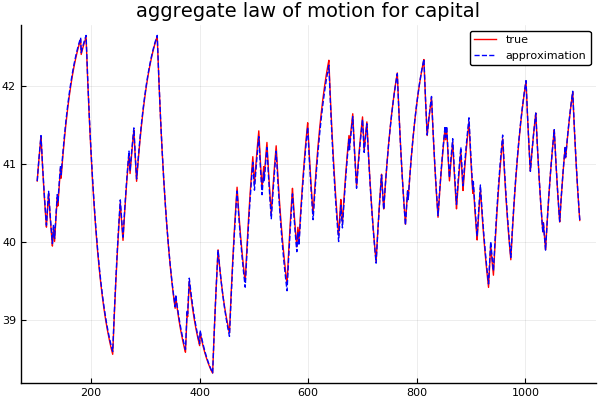

In [5]:
plot_ALM(ksp.z_grid, zi_shocks, kss.B,K_ts, T_discard = T_discard)

In [6]:
#kss.B  # Regression coefficient
println("Approximated aggregate capital law of motion")
println("log(K_{t+1})=$(kss.B[1])+$(kss.B[2])log(K_{t}) in good time (R2 = $(kss.R2[1]))")
println("log(K_{t+1})=$(kss.B[3])+$(kss.B[4])log(K_{t}) in bad time (R2 = $(kss.R2[2]))")

Approximated aggregate capital law of motion
log(K_{t+1})=0.1533888678582281+0.9592537018105605log(K_{t}) in good time (R2 = 0.9999965851470959)
log(K_{t+1})=0.14199999106533273+0.9609525795431593log(K_{t}) in bad time (R2 = 0.9999940336791976)


The approximated law of motion of capital is very close to the true one, which implies that assuming agents are partially rational is not bad idea since the difference of their actions are negligible.

The mean of capital, about 40, is  sufficiently close to Maliar et al. (2010).

In [7]:
@save "result_Euler.jld2" ksp kss 

In [8]:
# Compute mean of capital implied by regression
mc=MarkovChain(ksp.transmat.Pz)
sd=stationary_distributions(mc)[1]
logKg=kss.B[1]/(1-kss.B[2])
logKb=kss.B[3]/(1-kss.B[4])
meanK_reg=exp(sd[1]*logKg+sd[2]*logKb)
meanK_sim=mean(K_ts[T_discard+1:end])
println("mean of capital implied by regression is $meanK_reg")
println("mean of capital implied by simulation is $meanK_sim")

mean of capital implied by regression is 40.46934609899746
mean of capital implied by simulation is 40.67905048880162


## Figures in Krusell-Smith

Now, plot the replication figure:

### Figure 1

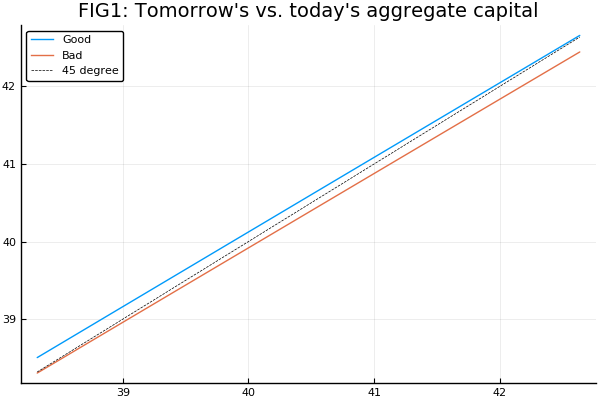

In [9]:
plot_Fig1(ksp ,kss, K_ts)

### Figure 2

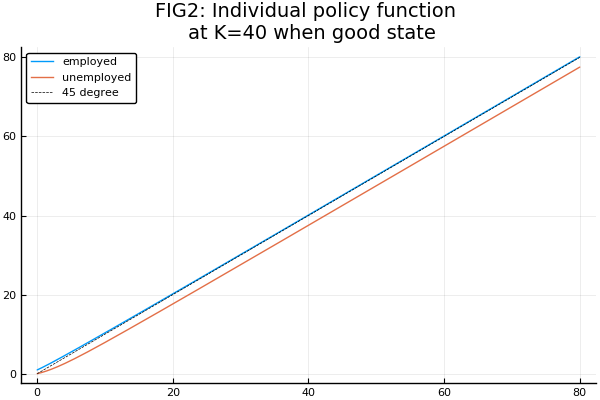

In [10]:
plot_Fig2(ksp, kss, 40)

Both figures are replicated well. 

# Solution with Young (2008)'s method
In this section, aggregate capital is simulated by the method of Young (2008).

In [11]:
kss = KSSolution(ksp, load_value=false, load_B=false)
ns = NonStochastic(ksp, zi_shocks[1])
@time K_ts = find_ALM_coef!(EulerMethod(), 
            ns, ksp, kss, zi_shocks, 
            tol_ump = 1e-8, max_iter_ump = 10000,
            tol_B = 1e-8, max_iter_B = 500, update_B = 0.3,
            T_discard = T_discard);

 --- Iteration over ALM coefficient: 1 ---


Solving individual UMP by Euler method:  Time: 0:00:52 (1868 iterations))
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.4561348316213136 and B = [0.456135, 0.877212, 0.436797, 0.880838]
 --- Iteration over ALM coefficient: 2 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:03


Solving individual UMP by Euler method:  Time: 0:00:48 (2006 iterations))
simulating aggregate path ... 92%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 0.008617043773197455 and B = [0.142877, 0.962002, 0.122422, 0.966001]
 --- Iteration over ALM coefficient: 3 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:31 (1375 iterations))
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.007375020667367477 and B = [0.146027, 0.961212, 0.128755, 0.964392]
 --- Iteration over ALM coefficient: 4 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:34 (1464 iterations))
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.005267484488800378 and B = [0.146131, 0.961154, 0.129092, 0.9643]
 --- Iteration over ALM coefficient: 5 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:32 (1345 iterations))
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.0040070314216140435 and B = [0.146451, 0.961065, 0.130024, 0.964064]
 --- Iteration over ALM coefficient: 6 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:31 (1329 iterations))
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.002959894299560145 and B = [0.146606, 0.961018, 0.130712, 0.963886]
 --- Iteration over ALM coefficient: 7 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:29 (1278 iterations))
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.002149672093765459 and B = [0.146684, 0.960994, 0.131256, 0.963744]
 --- Iteration over ALM coefficient: 8 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:28 (1228 iterations))
simulating aggregate path ... 83%|███████████████████   |  ETA: 0:00:00

difference of ALM coefficient is 0.001557972215212089 and B = [0.146711, 0.960985, 0.131645, 0.963643]
 --- Iteration over ALM coefficient: 9 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:03
Solving individual UMP by Euler method:  Time: 0:00:27 (1176 iterations))
simulating aggregate path ... 77%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 0.0013627235518748892 and B = [0.146715, 0.960982, 0.131917, 0.963572]
 --- Iteration over ALM coefficient: 10 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:26 (1124 iterations))
simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


difference of ALM coefficient is 0.0011429971537960382 and B = [0.146711, 0.960983, 0.132106, 0.963522]
 --- Iteration over ALM coefficient: 11 ---


Solving individual UMP by Euler method:  Time: 0:00:26 (1075 iterations))
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 0.000933283892693676 and B = [0.146706, 0.960983, 0.132239, 0.963487]
 --- Iteration over ALM coefficient: 12 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:24 (1028 iterations))
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.0007498547904362107 and B = [0.146704, 0.960984, 0.132336, 0.963462]
 --- Iteration over ALM coefficient: 13 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:23 (985 iterations)8)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.0005976751652848611 and B = [0.146705, 0.960983, 0.132409, 0.963443]
 --- Iteration over ALM coefficient: 14 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:22 (947 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.0004756173132779984 and B = [0.146711, 0.960982, 0.132466, 0.963428]
 --- Iteration over ALM coefficient: 15 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:21 (912 iterations)8)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 0.00037978251670364727 and B = [0.146718, 0.96098, 0.132513, 0.963416]
 --- Iteration over ALM coefficient: 16 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:21 (880 iterations))m
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.0003054532672387422 and B = [0.146728, 0.960977, 0.132552, 0.963406]
 --- Iteration over ALM coefficient: 17 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:19 (852 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.00024810888217277616 and B = [0.146738, 0.960974, 0.132587, 0.963397]
 --- Iteration over ALM coefficient: 18 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:19 (827 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.000203855571243583 and B = [0.146748, 0.960972, 0.132617, 0.963389]
 --- Iteration over ALM coefficient: 19 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:18 (804 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.00016953933124272402 and B = [0.146759, 0.960969, 0.132644, 0.963382]
 --- Iteration over ALM coefficient: 20 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:18 (782 iterations)8)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 0.00014270299955676524 and B = [0.146768, 0.960966, 0.132668, 0.963375]
 --- Iteration over ALM coefficient: 21 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:17 (762 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 0.00012147997353278983 and B = [0.146778, 0.960964, 0.132689, 0.96337]
 --- Iteration over ALM coefficient: 22 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:17 (744 iterations)8)
simulating aggregate path ... 93%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 0.00010447742525301895 and B = [0.146786, 0.960962, 0.132709, 0.963365]
 --- Iteration over ALM coefficient: 23 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:17 (725 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 9.066849963249024e-5 and B = [0.146794, 0.96096, 0.132726, 0.96336]
 --- Iteration over ALM coefficient: 24 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:16 (708 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 7.929176853394004e-5 and B = [0.146802, 0.960958, 0.132742, 0.963356]
 --- Iteration over ALM coefficient: 25 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:16 (691 iterations))m
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 6.97903851978876e-5 and B = [0.146809, 0.960956, 0.132756, 0.963352]
 --- Iteration over ALM coefficient: 26 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:15 (674 iterations)8)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 6.175582296052973e-5 and B = [0.146815, 0.960954, 0.132769, 0.963349]
 --- Iteration over ALM coefficient: 27 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:15 (658 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 5.488468390446588e-5 and B = [0.14682, 0.960953, 0.132781, 0.963346]
 --- Iteration over ALM coefficient: 28 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:14 (642 iterations)8)
simulating aggregate path ... 95%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 4.89512334236053e-5 and B = [0.146825, 0.960952, 0.132792, 0.963343]
 --- Iteration over ALM coefficient: 29 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:14 (626 iterations)8)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 4.37845498754974e-5 and B = [0.14683, 0.960951, 0.132801, 0.96334]
 --- Iteration over ALM coefficient: 30 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:14 (610 iterations)8)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 3.92541615132358e-5 and B = [0.146834, 0.960949, 0.13281, 0.963338]
 --- Iteration over ALM coefficient: 31 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:13 (595 iterations)8)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.5258409811500524e-5 and B = [0.146838, 0.960948, 0.132817, 0.963336]
 --- Iteration over ALM coefficient: 32 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:13 (579 iterations)8)
simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


difference of ALM coefficient is 3.1717546197990165e-5 and B = [0.146841, 0.960948, 0.132824, 0.963334]
 --- Iteration over ALM coefficient: 33 ---


Solving individual UMP by Euler method:  Time: 0:00:13 (564 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 2.8567378619087647e-5 and B = [0.146844, 0.960947, 0.132831, 0.963333]
 --- Iteration over ALM coefficient: 34 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:13 (548 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.5756294767614873e-5 and B = [0.146847, 0.960946, 0.132837, 0.963331]
 --- Iteration over ALM coefficient: 35 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:12 (533 iterations))m
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 2.3240819451986194e-5 and B = [0.14685, 0.960945, 0.132842, 0.96333]
 --- Iteration over ALM coefficient: 36 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:12 (518 iterations)8)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.0985733613115842e-5 and B = [0.146852, 0.960945, 0.132847, 0.963329]
 --- Iteration over ALM coefficient: 37 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:12 (503 iterations)8)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.896030110459801e-5 and B = [0.146854, 0.960944, 0.132851, 0.963327]
 --- Iteration over ALM coefficient: 38 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:11 (488 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.713855817897514e-5 and B = [0.146856, 0.960944, 0.132855, 0.963326]
 --- Iteration over ALM coefficient: 39 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:11 (473 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.5498205413494448e-5 and B = [0.146858, 0.960943, 0.132858, 0.963325]
 --- Iteration over ALM coefficient: 40 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:10 (458 iterations))m
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.4019786232499776e-5 and B = [0.146859, 0.960943, 0.132861, 0.963325]
 --- Iteration over ALM coefficient: 41 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:10 (443 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.2686044406962083e-5 and B = [0.146861, 0.960943, 0.132864, 0.963324]
 --- Iteration over ALM coefficient: 42 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


Solving individual UMP by Euler method:  Time: 0:00:10 (429 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.1481971272403468e-5 and B = [0.146862, 0.960942, 0.132867, 0.963323]
 --- Iteration over ALM coefficient: 43 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:09 (414 iterations)8)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.0394878791397666e-5 and B = [0.146863, 0.960942, 0.132869, 0.963323]
 --- Iteration over ALM coefficient: 44 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:09 (400 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 9.412208783921017e-6 and B = [0.146864, 0.960942, 0.132871, 0.963322]
 --- Iteration over ALM coefficient: 45 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:09 (385 iterations)8)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 8.523977039931463e-6 and B = [0.146865, 0.960941, 0.132873, 0.963322]
 --- Iteration over ALM coefficient: 46 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


Solving individual UMP by Euler method:  Time: 0:00:09 (371 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 7.72064266219008e-6 and B = [0.146866, 0.960941, 0.132875, 0.963321]
 --- Iteration over ALM coefficient: 47 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:08 (357 iterations)8)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 6.994028114354345e-6 and B = [0.146867, 0.960941, 0.132877, 0.963321]
 --- Iteration over ALM coefficient: 48 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:08 (344 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 6.336323091604701e-6 and B = [0.146867, 0.960941, 0.132878, 0.96332]
 --- Iteration over ALM coefficient: 49 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:08 (330 iterations)8)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 5.741289606842059e-6 and B = [0.146868, 0.960941, 0.132879, 0.96332]
 --- Iteration over ALM coefficient: 50 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:07 (316 iterations)8)
simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


difference of ALM coefficient is 5.20255477609588e-6 and B = [0.146869, 0.96094, 0.132881, 0.96332]
 --- Iteration over ALM coefficient: 51 ---


Solving individual UMP by Euler method:  Time: 0:00:07 (303 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 4.714489223428542e-6 and B = [0.146869, 0.96094, 0.132882, 0.963319]
 --- Iteration over ALM coefficient: 52 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:07 (290 iterations)8)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 4.272670644511756e-6 and B = [0.14687, 0.96094, 0.132883, 0.963319]
 --- Iteration over ALM coefficient: 53 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:06 (277 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 3.8725663447647385e-6 and B = [0.14687, 0.96094, 0.132883, 0.963319]
 --- Iteration over ALM coefficient: 54 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:06 (264 iterations)8)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 3.5099821105444295e-6 and B = [0.14687, 0.96094, 0.132884, 0.963319]
 --- Iteration over ALM coefficient: 55 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:06 (252 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 3.1813702160432555e-6 and B = [0.146871, 0.96094, 0.132885, 0.963318]
 --- Iteration over ALM coefficient: 56 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:05 (239 iterations)8)
simulating aggregate path ... 94%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 2.884014287607428e-6 and B = [0.146871, 0.96094, 0.132886, 0.963318]
 --- Iteration over ALM coefficient: 57 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:05 (228 iterations))m
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 2.613897075925964e-6 and B = [0.146871, 0.96094, 0.132886, 0.963318]
 --- Iteration over ALM coefficient: 58 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:05 (216 iterations)8)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 2.3698285921691653e-6 and B = [0.146872, 0.96094, 0.132887, 0.963318]
 --- Iteration over ALM coefficient: 59 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:05 (204 iterations)8)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 2.1483925622678424e-6 and B = [0.146872, 0.96094, 0.132887, 0.963318]
 --- Iteration over ALM coefficient: 60 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:04 (193 iterations)8)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.947404442897982e-6 and B = [0.146872, 0.96094, 0.132888, 0.963318]
 --- Iteration over ALM coefficient: 61 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:04 (182 iterations)8)
simulating aggregate path ... 96%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 1.7653895722224977e-6 and B = [0.146872, 0.96094, 0.132888, 0.963318]
 --- Iteration over ALM coefficient: 62 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:04 (172 iterations)8)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.6003569559552844e-6 and B = [0.146873, 0.960939, 0.132888, 0.963318]
 --- Iteration over ALM coefficient: 63 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:04 (161 iterations)8)
simulating aggregate path ... 93%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 1.4512411514178147e-6 and B = [0.146873, 0.960939, 0.132889, 0.963317]
 --- Iteration over ALM coefficient: 64 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


Solving individual UMP by Euler method:  Time: 0:00:03 (151 iterations)8)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.3154069426757342e-6 and B = [0.146873, 0.960939, 0.132889, 0.963317]
 --- Iteration over ALM coefficient: 65 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:03 (142 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.1924123506645845e-6 and B = [0.146873, 0.960939, 0.132889, 0.963317]
 --- Iteration over ALM coefficient: 66 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:03 (132 iterations)8)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.0814044617279972e-6 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 67 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:03 (123 iterations)8)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 9.802967592675849e-7 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 68 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:03 (115 iterations)8)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 8.885985442186328e-7 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 69 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (106 iterations)8)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 8.059627235879052e-7 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 70 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (98 iterations)08)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 7.306925396410868e-7 and B = [0.146873, 0.960939, 0.13289, 0.963317]
 --- Iteration over ALM coefficient: 71 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (91 iterations)08)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 6.623617018197692e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 72 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (83 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 6.010190553018546e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 73 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (77 iterations)8)m
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 5.445665013925627e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 74 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (70 iterations)08)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 4.942435950783253e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 75 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:02 (65 iterations)08)
simulating aggregate path ... 79%|██████████████████    |  ETA: 0:00:01

difference of ALM coefficient is 4.477099435074017e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 76 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:03
Solving individual UMP by Euler method:  Time: 0:00:01 (59 iterations)08)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 4.0644643303777706e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 77 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (55 iterations)08)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 3.6810898323969e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 78 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (50 iterations)08)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 3.342283573515292e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 79 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (47 iterations)08)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 3.024636119897117e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 80 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (44 iterations)8)m
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.7407118780020667e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 81 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (41 iterations)08)
simulating aggregate path ... 71%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.485447657130102e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 82 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (39 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.250508124301831e-7 and B = [0.146874, 0.960939, 0.132891, 0.963317]
 --- Iteration over ALM coefficient: 83 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (37 iterations)08)
simulating aggregate path ... 95%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 2.0398252301156994e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 84 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (35 iterations)8)m
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.8501803553117036e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 85 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (33 iterations)8)m
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.6791167115060013e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 86 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (32 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.51750390336991e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 87 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (30 iterations)08)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.3786970365359252e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 88 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (28 iterations)8)m
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.2521602682502575e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 89 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (27 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.1326223903207477e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 90 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (25 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.0293103455683017e-7 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 91 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (24 iterations)08)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 9.30346010230565e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 92 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:01 (22 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 8.464245168648965e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


 --- Iteration over ALM coefficient: 93 ---


Solving individual UMP by Euler method:  Time: 0:00:00 (21 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 7.652786657152966e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 94 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (19 iterations)8)m
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 6.974838753781576e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 95 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (19 iterations)08)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 6.263902901926244e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 96 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (17 iterations)8)m
simulating aggregate path ... 96%|██████████████████████|  ETA: 0:00:00

difference of ALM coefficient is 5.709994851943456e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 97 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (16 iterations)8)m
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 5.174000020091718e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 98 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (15 iterations)08)
simulating aggregate path ... 95%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 4.6844407131096943e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 99 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (14 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 4.254244148627073e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 100 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


Solving individual UMP by Euler method:  Time: 0:00:00 (14 iterations)08)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 3.804459813849803e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]

simulating aggregate path ...100%|██████████████████████| Time: 0:00:02



 --- Iteration over ALM coefficient: 101 ---


Solving individual UMP by Euler method:  Time: 0:00:00 (12 iterations)08)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 3.4976016666243837e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 102 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (12 iterations)08)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 3.1486846935324664e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 103 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (10 iterations)08)
simulating aggregate path ... 93%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 2.904139495552016e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 104 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (11 iterations)08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 2.5656462981915595e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 105 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (9 iterations)-08)
simulating aggregate path ... 75%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 2.3675274851697736e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 106 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (9 iterations)-08)
simulating aggregate path ... 94%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 2.1270876116030735e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 107 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (8 iterations)08)
simulating aggregate path ... 73%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.9416610569367165e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 108 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


Solving individual UMP by Euler method:  Time: 0:00:00 (8 iterations)-08)
simulating aggregate path ... 73%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.7361788201553097e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 109 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (7 iterations)08)
simulating aggregate path ... 94%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 1.5907071271303863e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 110 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (6 iterations)-08)
simulating aggregate path ... 87%|████████████████████  |  ETA: 0:00:00

difference of ALM coefficient is 1.468659144299167e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 111 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (6 iterations)-08)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.318548634166028e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 112 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by Euler method:  Time: 0:00:00 (6 iterations)-08)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 1.1777319147698861e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 113 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 1.078307437785142e-8 and B = [0.146874, 0.960939, 0.132892, 0.963317]
 --- Iteration over ALM coefficient: 114 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 9.680553608726328e-9 and B = [0.146874, 0.960939, 0.132892, 0.963317]
-----------------------------------------------------
ALM coefficient successfully converged : dif = 9.680553608726328e-9
-----------------------------------------------------
1273.846153 seconds (7.95 G allocations: 1.278 TiB, 15.51% gc time)


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


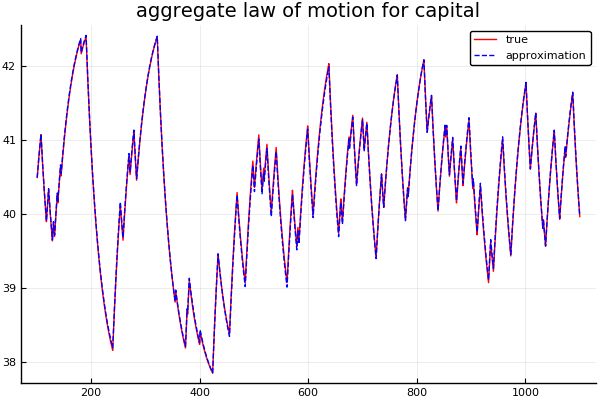

In [12]:
plot_ALM(ksp.z_grid, zi_shocks, kss.B,K_ts, T_discard = T_discard)

In [13]:
#kss.B  # Regression coefficient
println("Approximated aggregate capital law of motion")
println("log(K_{t+1})=$(kss.B[1])+$(kss.B[2])log(K_{t}) in good time (R2 = $(kss.R2[1]))")
println("log(K_{t+1})=$(kss.B[3])+$(kss.B[4])log(K_{t}) in bad time (R2 = $(kss.R2[2]))")

Approximated aggregate capital law of motion
log(K_{t+1})=0.1468742297741828+0.9609390142949115log(K_{t}) in good time (R2 = 0.9999985643122742)
log(K_{t+1})=0.1328919612162856+0.9633166115209159log(K_{t}) in bad time (R2 = 0.9999976186272014)


In [14]:
@save "result_Young.jld2" ksp kss 

In [15]:
# Compute mean of capital implied by regression
mc=MarkovChain(ksp.transmat.Pz)
sd=stationary_distributions(mc)[1]
logKg=kss.B[1]/(1-kss.B[2])
logKb=kss.B[3]/(1-kss.B[4])
meanK_reg=exp(sd[1]*logKg+sd[2]*logKb)
meanK_sim=mean(K_ts[T_discard+1:end])
println("mean of capital implied by regression is $meanK_reg")
println("mean of capital implied by simulation is $meanK_sim")

mean of capital implied by regression is 40.1009518847617
mean of capital implied by simulation is 40.350045260575776


## Figures in Krusell-Smith

### Figure 1

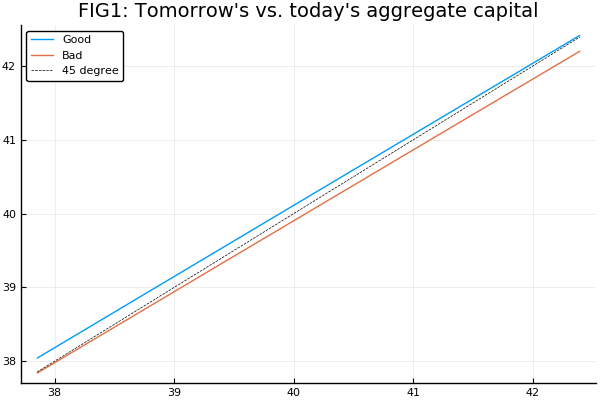

In [16]:
plot_Fig1(ksp ,kss, K_ts)

### Figure 2

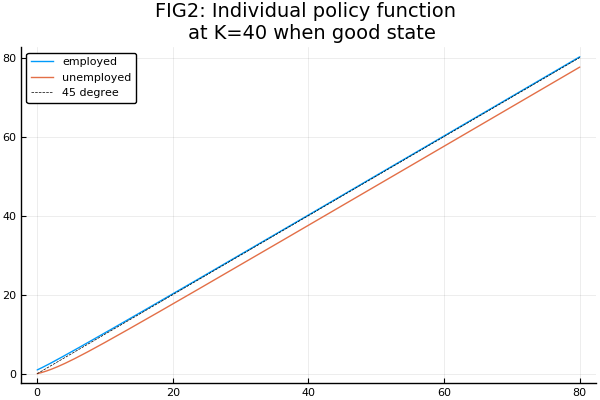

In [17]:
plot_Fig2(ksp, kss, 40)

# Solution with value function iteration
In this section, each agent's utility maximization problem is solved by value function iteration.

## Implementation

Let's skip the following steps in this section to save computational time.
- consturuction of `ksp` instance since it is same
- consturuction of `kss` instance to use the previous result as initial guess of the solution
- draws of the shocks to use same ones

However, instead of constructing `kss` again, obtain value from the policy function derived by Euler method:

In [18]:
iterate_policy!(ksp, kss, n_iter=30)

Young's non-stochastic method is used for simuation.

In [19]:
kss = KSSolution(ksp, load_value=false, load_B=false)
ns = NonStochastic(ksp, zi_shocks[1])
@time K_ts = find_ALM_coef!(VFI(Howard_on=false, Howard_n_iter=20),
                ns, ksp, kss, zi_shocks, 
            tol_ump = 1e-8, max_iter_ump = 10000,
            tol_B = 1e-8, max_iter_B = 500, update_B = 0.3,
            T_discard = T_discard);

 --- Iteration over ALM coefficient: 1 ---


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0106e-08)m

 ** VFI converged successfully!! dif = 9.994721494877012e-9


Solving individual UMP by VFI:  Time: 0:07:55 (1736 iterations)
simulating aggregate path ... 83%|███████████████████   |  ETA: 0:00:00

difference of ALM coefficient is 0.428805175480162 and B = [0.428805, 0.884554, 0.410498, 0.887896]
 --- Iteration over ALM coefficient: 2 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00532e-08)

 ** VFI converged successfully!! dif = 9.939441270034877e-9


Solving individual UMP by VFI:  Time: 0:05:29 (1256 iterations)
simulating aggregate path ... 82%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 0.014460894014056674 and B = [0.143102, 0.961781, 0.114063, 0.96817]
 --- Iteration over ALM coefficient: 3 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00066e-08)

 ** VFI converged successfully!! dif = 9.893028618535027e-9


Solving individual UMP by VFI:  Time: 0:05:17 (1188 iterations)
simulating aggregate path ... 89%|████████████████████  |  ETA: 0:00:00

difference of ALM coefficient is 0.011577595533557777 and B = [0.144557, 0.961503, 0.119452, 0.966854]
 --- Iteration over ALM coefficient: 4 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00553e-08)

 ** VFI converged successfully!! dif = 9.941516054823296e-9


Solving individual UMP by VFI:  Time: 0:04:34 (1003 iterations)
simulating aggregate path ... 82%|███████████████████   |  ETA: 0:00:00

difference of ALM coefficient is 0.00672525014133743 and B = [0.143178, 0.96185, 0.118426, 0.967128]
 --- Iteration over ALM coefficient: 5 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00691e-08)

 ** VFI converged successfully!! dif = 9.952884738595458e-9


Solving individual UMP by VFI:  Time: 0:03:35 (808 iterations)
simulating aggregate path ... 80%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 0.0041543727804939645 and B = [0.142625, 0.961995, 0.118337, 0.967161]
 --- Iteration over ALM coefficient: 6 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0075e-08)m

 ** VFI converged successfully!! dif = 9.96114124518499e-9


Solving individual UMP by VFI:  Time: 0:02:60 (686 iterations)
simulating aggregate path ... 83%|███████████████████   |  ETA: 0:00:00

difference of ALM coefficient is 0.0025803524375948572 and B = [0.142297, 0.962079, 0.118271, 0.967184]
 --- Iteration over ALM coefficient: 7 ---

simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.03562e-08)

 ** VFI converged successfully!! dif = 9.966854008780501e-9


Solving individual UMP by VFI:  Time: 0:02:47 (642 iterations)
simulating aggregate path ... 83%|███████████████████   |  ETA: 0:00:00

difference of ALM coefficient is 0.0016218195891860299 and B = [0.142113, 0.962125, 0.118257, 0.967191]
 --- Iteration over ALM coefficient: 8 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00832e-08)

 ** VFI converged successfully!! dif = 9.961809155356605e-9


Solving individual UMP by VFI:  Time: 0:03:10 (605 iterations)
simulating aggregate path ... 89%|████████████████████  |  ETA: 0:00:00

difference of ALM coefficient is 0.0010273799823305452 and B = [0.142005, 0.962152, 0.118259, 0.967192]
 --- Iteration over ALM coefficient: 9 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01004e-08)

 ** VFI converged successfully!! dif = 9.978975867852569e-9


Solving individual UMP by VFI:  Time: 0:02:54 (573 iterations)
simulating aggregate path ... 93%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 0.0006554489272417308 and B = [0.141941, 0.962168, 0.118267, 0.967192]
 --- Iteration over ALM coefficient: 10 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:03
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01048e-08)

 ** VFI converged successfully!! dif = 9.96641347228433e-9


Solving individual UMP by VFI:  Time: 0:02:47 (539 iterations)
simulating aggregate path ... 80%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 0.00042016726753904554 and B = [0.141903, 0.962178, 0.118276, 0.96719]
 --- Iteration over ALM coefficient: 11 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01166e-08)

 ** VFI converged successfully!! dif = 9.994266747526126e-9


Solving individual UMP by VFI:  Time: 0:02:31 (503 iterations)
simulating aggregate path ... 77%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 0.0002703569084139268 and B = [0.141879, 0.962184, 0.118283, 0.967189]
 --- Iteration over ALM coefficient: 12 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0025e-08)m

 ** VFI converged successfully!! dif = 9.903544651024276e-9


Solving individual UMP by VFI:  Time: 0:02:25 (471 iterations)
simulating aggregate path ... 70%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 0.0001747881005138563 and B = [0.141864, 0.962187, 0.118289, 0.967188]


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


 --- Iteration over ALM coefficient: 13 ---


Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01129e-08)

 ** VFI converged successfully!! dif = 9.989889804273844e-9


Solving individual UMP by VFI:  Time: 0:02:01 (436 iterations)
simulating aggregate path ... 79%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 0.00011310615847315297 and B = [0.141855, 0.962189, 0.118293, 0.967187]
 --- Iteration over ALM coefficient: 14 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00514e-08)

 ** VFI converged successfully!! dif = 9.928498911904171e-9


Solving individual UMP by VFI:  Time: 0:01:56 (402 iterations)
simulating aggregate path ... 93%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 7.32621346145601e-5 and B = [0.141849, 0.962191, 0.118296, 0.967186]
 --- Iteration over ALM coefficient: 15 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00943e-08)

 ** VFI converged successfully!! dif = 9.970108294510283e-9


Solving individual UMP by VFI:  Time: 0:01:42 (368 iterations)
simulating aggregate path ... 74%|█████████████████     |  ETA: 0:00:01

difference of ALM coefficient is 4.770718960114828e-5 and B = [0.141846, 0.962191, 0.118298, 0.967186]
 --- Iteration over ALM coefficient: 16 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00158e-08)

 ** VFI converged successfully!! dif = 9.891550689644646e-9


Solving individual UMP by VFI:  Time: 0:01:57 (334 iterations)
simulating aggregate path ... 91%|█████████████████████ |  ETA: 0:00:00

difference of ALM coefficient is 3.090272309547171e-5 and B = [0.141843, 0.962192, 0.1183, 0.967186]
 --- Iteration over ALM coefficient: 17 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0051e-08)m

 ** VFI converged successfully!! dif = 9.926452548825182e-9


Solving individual UMP by VFI:  Time: 0:01:29 (308 iterations)
simulating aggregate path ... 81%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 2.0087004701296873e-5 and B = [0.141842, 0.962192, 0.1183, 0.967186]
 --- Iteration over ALM coefficient: 18 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:03
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01298e-08)

 ** VFI converged successfully!! dif = 9.999837402574485e-9


Solving individual UMP by VFI:  Time: 0:01:18 (258 iterations)
simulating aggregate path ... 79%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 1.3064436913179378e-5 and B = [0.141841, 0.962193, 0.118301, 0.967185]
 --- Iteration over ALM coefficient: 19 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00138e-08)

 ** VFI converged successfully!! dif = 9.88967485682224e-9


Solving individual UMP by VFI:  Time: 0:01:17 (255 iterations)
simulating aggregate path ... 72%|████████████████      |  ETA: 0:00:01

difference of ALM coefficient is 8.69738075323645e-6 and B = [0.14184, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 20 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00476e-08)

 ** VFI converged successfully!! dif = 9.919460808305303e-9


Solving individual UMP by VFI:  Time: 0:01:34 (206 iterations)
simulating aggregate path ... 89%|████████████████████  |  ETA: 0:00:00

difference of ALM coefficient is 5.468240175970918e-6 and B = [0.14184, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 21 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01033e-08)

 ** VFI converged successfully!! dif = 9.976076853490667e-9


Solving individual UMP by VFI:  Time: 0:00:55 (174 iterations)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 3.580045910361873e-6 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 22 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00782e-08)

 ** VFI converged successfully!! dif = 9.948990964403492e-9


Solving individual UMP by VFI:  Time: 0:00:44 (135 iterations)
simulating aggregate path ... 79%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 2.2968971356840395e-6 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 23 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00779e-08)

 ** VFI converged successfully!! dif = 9.9573185252666e-9


Solving individual UMP by VFI:  Time: 0:00:45 (161 iterations)
simulating aggregate path ... 80%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 1.520622740197597e-6 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 24 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.02691e-08)

 ** VFI converged successfully!! dif = 9.996881544793723e-9


Solving individual UMP by VFI:  Time: 0:00:22 (85 iterations)
simulating aggregate path ... 80%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 9.749422733851265e-7 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 25 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01489e-08)

 ** VFI converged successfully!! dif = 9.94174342849874e-9


Solving individual UMP by VFI:  Time: 0:00:19 (72 iterations)
simulating aggregate path ... 81%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 6.30561285019926e-7 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 26 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00036e-08)

 ** VFI converged successfully!! dif = 9.854176141743665e-9


Solving individual UMP by VFI:  Time: 0:00:24 (91 iterations)
simulating aggregate path ... 80%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 4.689234013866006e-7 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 27 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.03537e-08)

 ** VFI converged successfully!! dif = 9.96635662886547e-9


Solving individual UMP by VFI:  Time: 0:00:15 (57 iterations)
simulating aggregate path ... 76%|█████████████████     |  ETA: 0:00:00

difference of ALM coefficient is 3.1492881336081524e-7 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 28 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.00153e-08)

 ** VFI converged successfully!! dif = 9.578542403687607e-9


Solving individual UMP by VFI:  Time: 0:00:13 (50 iterations)
simulating aggregate path ... 81%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 1.5169019318417298e-7 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 29 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01037e-08)

 ** VFI converged successfully!! dif = 9.968800895876484e-9


Solving individual UMP by VFI:  Time: 0:00:21 (69 iterations)
simulating aggregate path ... 79%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 1.705320638450969e-7 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 30 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.0077e-08)m

 ** VFI converged successfully!! dif = 9.860116279014619e-9


Solving individual UMP by VFI:  Time: 0:00:11 (43 iterations)
simulating aggregate path ... 82%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 1.3195634965268432e-7 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 31 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.03134e-08)

 ** VFI converged successfully!! dif = 9.833968306338647e-9


Solving individual UMP by VFI:  Time: 0:00:08 (30 iterations)
simulating aggregate path ... 80%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 4.341085224623953e-8 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 32 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.02358e-08)

 ** VFI converged successfully!! dif = 9.643912335377536e-9


Solving individual UMP by VFI:  Time: 0:00:05 (21 iterations)
simulating aggregate path ... 80%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 4.6830600647362886e-8 and B = [0.141839, 0.962193, 0.118302, 0.967185]
 --- Iteration over ALM coefficient: 33 ---


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02
Solving individual UMP by VFI:  (thresh = 1e-08, value = 1.01893e-08)

 ** VFI converged successfully!! dif = 9.76172032096656e-9


Solving individual UMP by VFI:  Time: 0:00:09 (33 iterations)
simulating aggregate path ... 78%|██████████████████    |  ETA: 0:00:00

difference of ALM coefficient is 6.680717812290737e-9 and B = [0.141839, 0.962193, 0.118302, 0.967185]
-----------------------------------------------------
ALM coefficient successfully converged : dif = 6.680717812290737e-9
-----------------------------------------------------
3935.643705 seconds (29.98 G allocations: 5.733 TiB, 16.24% gc time)


simulating aggregate path ...100%|██████████████████████| Time: 0:00:02


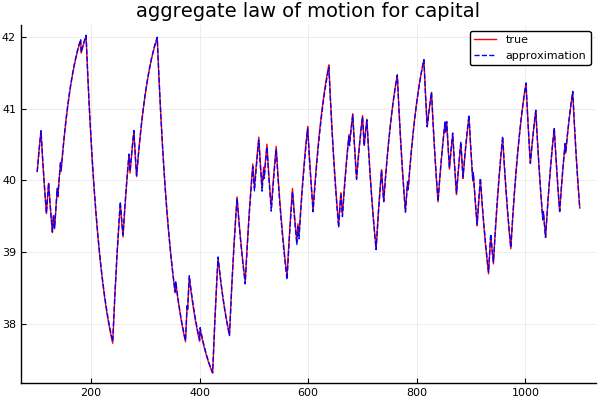

In [20]:
plot_ALM(ksp.z_grid, zi_shocks, kss.B, K_ts, T_discard = T_discard)

In [21]:
#kss.B  # Regression coefficient
println("Approximated aggregate capital law of motion")
println("log(K_{t+1})=$(kss.B[1])+$(kss.B[2])log(K_{t}) in good time (R2 = $(kss.R2[1]))")
println("log(K_{t+1})=$(kss.B[3])+$(kss.B[4])log(K_{t}) in bad time (R2 = $(kss.R2[2]))")

Approximated aggregate capital law of motion
log(K_{t+1})=0.14183884897222415+0.962193057333297log(K_{t}) in good time (R2 = 0.9999993082093952)
log(K_{t+1})=0.11830233274973227+0.9671851357222669log(K_{t}) in bad time (R2 = 0.9999989625914406)


In [22]:
@save "result_VFI.jld2" ksp kss 

In [23]:
# Compute mean of capital implied by regression
mc = MarkovChain(ksp.transmat.Pz)
sd = stationary_distributions(mc)[1]
logKg = kss.B[1]/(1-kss.B[2])
logKb = kss.B[3]/(1-kss.B[4])
meanK_reg = exp(sd[1]*logKg + sd[2]*logKb)
meanK_sim = mean(K_ts[T_discard+1:end])
println("mean of capital implied by regression is $meanK_reg")
println("mean of capital implied by simulation is $meanK_sim")

mean of capital implied by regression is 39.58313131174572
mean of capital implied by simulation is 39.94733411715162


## Figures in Krusell-Smith

### Figure 1

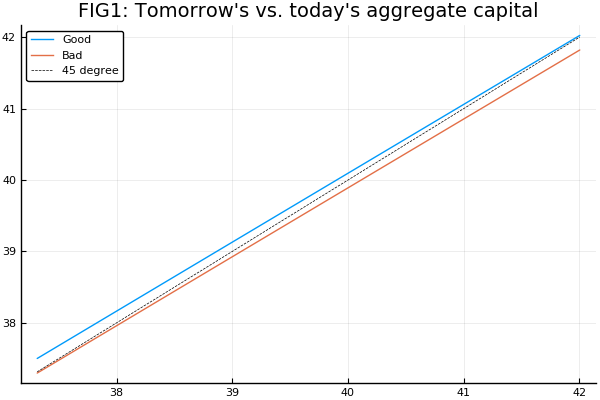

In [24]:
plot_Fig1(ksp, kss, K_ts)

### Figure 2

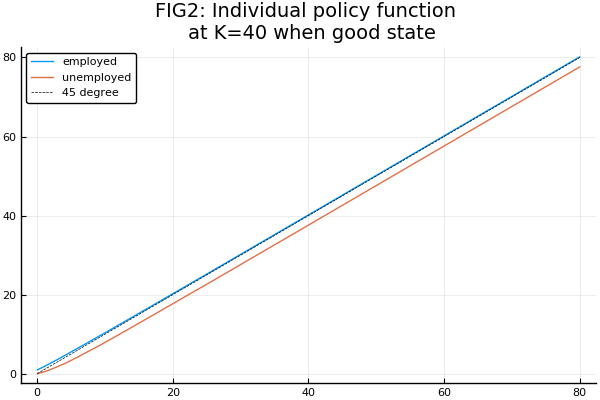

In [25]:
plot_Fig2(ksp, kss, 40)